# Data Collection

#### 🧾 IST History - Station List

A station list to be used with the data files, showing the names and locations for each station.

- **USAF**: Air Force station ID. May contain a letter in the first position.  
- **WBAN**: NCDC WBAN number  
- **CTRY**: FIPS country ID  
- **ST**: State for US stations  
- **ICAO**: ICAO ID  
- **LAT**: Latitude in thousandths of decimal degrees  
- **LON**: Longitude in thousandths of decimal degrees  
- **ELEV**: Elevation in meters  
- **BEGIN**: Beginning Period Of Record (YYYYMMDD). May have reporting gaps.  
- **END**: Ending Period Of Record (YYYYMMDD). May have reporting gaps.  


---


#### 🌦️ DailyWeather - Global Surface Summary of the Day

Produced by the National Climatic Data Center (NCDC), Asheville, NC.

| Field   | Position    | Type   | Description |
|---------|-------------|--------|-------------|
| STN---  | 1–6         | Int    | Station number (WMO/DATSAV3 number) |
| WBAN    | 8–12        | Int    | WBAN number ("Weather Bureau Air Force Navy- Missing: 99999") |
| YEAR    | 15–18       | Int    | The year |
| MODA    | 19–22       | Int    | Month and day |
| TEMP    | 25–30       | Real   | Mean temperature (°F to tenths) — Missing: 9999.9 |
| Count   | 32–33       | Int    | Obs count for mean temperature |
| DEWP    | 36–41       | Real   | Mean dew point (°F to tenths) — Missing: 9999.9 |
| Count   | 43–44       | Int    | Obs count for dew point |
| SLP     | 47–52       | Real   | Mean sea-level pressure (mb) — Missing: 9999.9 |
| Count   | 54–55       | Int    | Obs count for sea-level pressure |
| STP     | 58–63       | Real   | Mean station pressure (mb) — Missing: 9999.9 |
| Count   | 65–66       | Int    | Obs count for station pressure |
| VISIB   | 69–73       | Real   | Mean visibility (miles) — Missing: 999.9 |
| Count   | 75–76       | Int    | Obs count for visibility |
| WDSP    | 79–83       | Real   | Mean wind speed (knots) — Missing: 999.9 |
| Count   | 85–86       | Int    | Obs count for wind speed |
| MXSPD   | 89–93       | Real   | Max sustained wind speed (knots) — Missing: 999.9 |
| GUST    | 96–100      | Real   | Max wind gust (knots) — Missing: 999.9 |
| MAX     | 103–108     | Real   | Max temperature (°F) — Missing: 9999.9 |
| Flag    | 109         | Char   | Blank = from max report; * = derived from hourly |
| MIN     | 111–116     | Real   | Min temperature (°F) — Missing: 9999.9 |
| Flag    | 117         | Char   | Same rules as MAX |
| PRCP    | 119–123     | Real   | Precipitation (inches) — Missing: 99.99 |
| Flag    | 124         | Char   | A–I, source info for precipitation |
| SNDP    | 126–130     | Real   | Snow depth (inches) — Missing: 999.9 |
| FRSHTT  | 133–138     | Int    | Flags for Fog, Rain, Snow, Hail, Thunder, Tornado (1 = yes, 0 = no) |



# Data Cleaning

Take only US stations from ISD History

In [3]:
import pandas as pd

df = pd.read_csv('/content/isd-history.csv')
print("Total number of weather stations in ISD History", len(df))

# Filter for rows with COUNTRY == 'US', non-null ICAO, WBAN !=9999
filtered_df = df[(df['CTRY'] == 'US') & (df['ICAO'].notna()) & (df['WBAN'] != 9999)]
print("Number of US weather stations in ISD History", len(filtered_df))

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('ISD_History_US.csv', index=False)
filtered_df.head()

Total number of weather stations in ISD History 29775
Number of US weather stations in ISD History 5080


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
14469,690020,93218,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,19640715,19970401
14470,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,20030702,20030801
14471,690070,93217,FRITZSCHE AAF,US,CA,KOAR,36.683,-121.767,43.0,19600404,19930831
14478,690140,93101,EL TORO MCAS,US,CA,KNZJ,33.667,-117.733,116.7,19890101,19990630
14479,690150,93121,TWENTY NINE PALMS,US,CA,KNXP,34.300,-116.167,625.1,19900102,20190416


Extract data for years 1998-2002 from the tar files

In [5]:
import tarfile
import gzip
import pandas as pd
import io

# The paths to your yearly tar files
# tar_years = [1998, 1999]
tar_years = [2000, 2001, 2002]

# Get Columns based on the file format
colspecs = [
    (0, 6),    # STN--- (USAF weather station ID)
    (7, 12),   # WBAN
    (13, 18),  # YEAR
    (19, 22),  # MODA (Month/Day)
    (24, 30),  # TEMP (mean temperature)
    (30, 33),  # TEMP count
    (35, 41),  # DEWP (mean dewpoint)
    (41, 44),  # DEWP count
    (46, 52),  # SLP (mean sea level pressure)
    (52, 55),  # SLP count
    (57, 63),  # STP (mean station pressure)
    (63, 66),  # STP count
    (68, 74),  # VISIB (mean visibility)
    (74, 77),  # VISIB count
    (79, 85),  # WDSP (mean wind speed)
    (85, 88),  # WDSP count
    (90, 96),  # MXSPD (max wind speed)
    (96, 101), # GUST (max gust speed)
    (103, 109),# MAX (max temperature)
    (110, 116),# MIN (min temperature)
    (118, 123),# PRCP (precipitation)
    (125, 130),# SNDP (snow depth)
    (132, 138) # FRSHTT (indicator flags)
]

# Define column names corresponding to the colspecs above
col_names = [
    "STN", "WBAN", "YEAR", "MODA",
    "TEMP", "TEMP_Count",
    "DEWP", "DEWP_Count",
    "SLP",  "SLP_Count",
    "STP",  "STP_Count",
    "VISIB","VISIB_Count",
    "WDSP", "WDSP_Count",
    "MXSPD","GUST",
    "MAX",  "MIN",
    "PRCP", "SNDP",
    "FRSHTT"
]

all_dfs = []

for year in tar_years:
    tar_path = f"/content/gsod_{year}.tar"
    print(f"Processing: {tar_path}")

    with tarfile.open(tar_path, "r") as year_tar:
        # Loop through each member in the main yearly tar
        for member in year_tar.getmembers():
            # We only care about .op.gz files
            if member.isfile() and member.name.endswith(".op.gz"):
                file_obj = year_tar.extractfile(member)

                if file_obj is not None:
                    # Decompress the .gz in memory
                    with gzip.open(file_obj, "rt", errors="replace") as gz:
                        try:
                            # Read the fixed-width file directly with pandas
                            df = pd.read_fwf(
                                gz,
                                colspecs=colspecs,
                                names=col_names,
                                header=None,
                                skiprows=1  # Remove if no header lines
                            )
                            all_dfs.append(df)
                        except Exception as e:
                            print(f"Error parsing {member.name} from {tar_path}: {e}")

# Combine everything
final_df = pd.concat(all_dfs, ignore_index=True)

# Save to CSV
# output_csv = "gsod_merged_1998_1999.csv"
output_csv = "gsod_merged_2000_2002.csv"
final_df.to_csv(output_csv, index=False)
print(f"{tar_years} merged into: {output_csv}")

Processing: /content/gsod_2000.tar
Processing: /content/gsod_2001.tar
Processing: /content/gsod_2002.tar
[2000, 2001, 2002] merged into: gsod_merged_2000_2002.csv


Keep only april weather data for all years

In [6]:
import pandas as pd

# Concatenate all years
df1 = pd.read_csv('gsod_merged_1998_1999.csv')
df2 = pd.read_csv('gsod_merged_2000_2002.csv')
merged_df = pd.concat([df1, df2], ignore_index=True)
print("Total records in the weather dataset", len(merged_df))

# Optional: filter weather to April only
merged_df["MODA"] = merged_df["MODA"].astype(int)

# Filter for April (month = 4) and years 1998 to 2002
merged_df = merged_df[
    (merged_df["YEAR"].between(1998, 2002)) &
    ((merged_df["MODA"] // 100) == 4)
]

print("Total records in the weather dataset for april", len(merged_df))

# Drop rows where WBAN column equals 99999, Invalid stations
merged_df = merged_df[merged_df['WBAN'] != 99999]
print("Total records in the weather dataset for correct weather stations", len(merged_df))

merged_df.to_csv("/content/Daily_Weather_April.csv", index=False)
merged_df.head()

Total records in the weather dataset 13053781
Total records in the weather dataset for april 1069919
Total records in the weather dataset for correct weather stations 88112


,STN,WBAN,YEAR,MODA,TEMP,TEMP_Count,DEWP,DEWP_Count,SLP,SLP_Count,...,VISIB_Count,WDSP,WDSP_Count,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT
25994,747686,13820,1998,401,65.5,24,57.8,24,1014.7,19,...,24,6.7 2,4,3.0 9,99.9,75.2,55.4,0.83,999.9,10010
25995,747686,13820,1998,402,66.8,24,63.7,24,1015.4,15,...,24,3.9 2,4,8.0 9,99.9,75.2*,60.8,0.00,999.9,10000
25996,747686,13820,1998,403,73.3,24,71.4,24,1011.7,15,...,24,10.4 2,4,5.9,21.0,78.8*,69.8,0.21,999.9,10000
25997,747686,13820,1998,404,67.9,24,55.2,24,1010.8,24,...,24,8.3 2,4,2.0,16.9,78.8,57.2,0.15,999.9,0
25998,747686,13820,1998,405,56.7,24,45.3,24,1014.8,24,...,24,8.3 2,4,3.0 9,99.9,71.6,46.4,0.00,999.9,0


Replace all missing values with NA

In [7]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/Daily_Weather_April.csv")

# Replace known missing flags with NaN
missing_value_map = {
    "TEMP": 9999.9,
    "DEWP": 9999.9,
    "SLP": 9999.9,
    "STP": 9999.9,
    "VISIB": 999.9,
    "WDSP": 999.9,
    "MXSPD": 999.9,
    "GUST": 999.9,
    "MAX": 9999.9,
    "MIN": 9999.9,
    "PRCP": 99.99,
    "SNDP": 999.9
}

# Convert and clean
for col, missing_val in missing_value_map.items():
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].replace(missing_val, pd.NA)

df.to_csv("/content/Cleaned_Daily_Weather.csv", index=False)
print("Cleaned dataset saved as cleaned_daily_weather.csv")


Cleaned dataset saved as cleaned_daily_weather.csv


# Data Integration

Merge Daily weather and ist history based on WBAN for getting ICAO code, for finding flight IATA

In [8]:
import pandas as pd
from tqdm import tqdm

# Load the CSV files
weather_df = pd.read_csv("/content/Cleaned_Daily_Weather.csv", skipinitialspace=True)
stations_df = pd.read_csv("/content/ISD_History_US.csv", skipinitialspace=True)

# Strip whitespaces from column names
stations_df.columns = stations_df.columns.str.strip()
weather_df.columns = weather_df.columns.str.strip()

# Ensure WBANs are strings to match properly
weather_df['WBAN'] = weather_df['WBAN'].astype(str).str.strip()
stations_df['WBAN'] = stations_df['WBAN'].astype(str).str.strip()

# Create a dictionary for quick lookup of station rows by WBAN
station_lookup = stations_df.drop_duplicates(subset="WBAN").set_index("WBAN").to_dict(orient='index')

# Prepare merged output list
merged_records = []

# Iterate over weather data
for _, weather_row in tqdm(weather_df.iterrows(), total=len(weather_df), desc="Merging ICAO info", ncols=100):
    wban = weather_row['WBAN']
    station_info = station_lookup.get(wban, None)

    if station_info:
        combined_row = weather_row.to_dict()
        combined_row.update(station_info)
        merged_records.append(combined_row)
    else:
        # Keep the original weather row if no match found
        merged_records.append(weather_row.to_dict())

# Create final DataFrame
final_df = pd.DataFrame(merged_records)

# Save the merged file
final_df.to_csv("/content/Daily_Weather_ICAO.csv", index=False)
print(f"Successfully merged {len(final_df)} records and saved to Daily_Weather_ICAO.csv")


Merging ICAO info: 100%|███████████████████████████████████| 88112/88112 [00:06<00:00, 13138.37it/s]


Successfully merged 88112 records and saved to Daily_Weather_ICAO.csv


Use airportsdata package to convert ICAO into IATA code

In [9]:
!pip install airportsdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.7/913.7 kB 9.8 MB/s eta 0:00:00


In [10]:
import pandas as pd
from airportsdata import load

# Load global airport data using ICAO codes
airports = load('ICAO')

# Read the merged weather-station data
df = pd.read_csv("/content/Daily_Weather_ICAO.csv")

# Map ICAO to IATA using the airport database
def icao_to_iata(icao_code):
    airport = airports.get(icao_code)
    return airport['iata'] if airport else None

# Add IATA column
df['IATA'] = df['ICAO'].apply(icao_to_iata)
print(f"Total records: {len(df)}")

# Drop rows where IATA is missing (null)
df_cleaned = df.dropna(subset=['IATA'])

# Print the count of remaining records
print(f"Records with valid IATA code: {len(df_cleaned)}")

# Save the cleaned dataset (optional)
df_cleaned.to_csv("/content/Daily_Weather_IATA.csv", index=False)


Total records: 88112
Records with valid IATA code: 79767


Create a common column in weatherdata for merging weather and airport data: DDMMYYYYYIATA

In [11]:
import pandas as pd

# Load the weather dataset
weather_df = pd.read_csv("/content/Daily_Weather_IATA.csv")

def convert_to_ddmmyyyy_iata(row):
    # Extract year, MODA, and IATA
    year = row['YEAR']
    mod = str(row['MODA']).zfill(3)
    iata = row['IATA']

    # Extract month (first digit) and day (next two digits)
    month = "0"+mod[0]  # First digit as month
    day = mod[1:3]  # Next two digits as day

    # Create the formatted string as DDMMYYYYIATA
    formatted_date = f"{day}{month}{year}{iata}"

    return formatted_date

# Apply the conversion to each row and create the new column
weather_df['DDMMYYYYIATA'] = weather_df.apply(convert_to_ddmmyyyy_iata, axis=1)

weather_df.drop_duplicates(subset="DDMMYYYYIATA", inplace=True)
print(len(weather_df))

# Display the result (first few rows)
print(weather_df[['YEAR', 'MODA', 'IATA', 'DDMMYYYYIATA']].head())

# Optional: Save the updated dataset
weather_df.to_csv("/content/Final_Weather_Data.csv", index=False)

77168
   YEAR  MODA IATA DDMMYYYYIATA
0  1998   401  BIX  01041998BIX
1  1998   402  BIX  02041998BIX
2  1998   403  BIX  03041998BIX
3  1998   404  BIX  04041998BIX
4  1998   405  BIX  05041998BIX


See missing value columns in the weather data

In [1]:
import pandas as pd

# Load the weather data
df = pd.read_csv('/content/Final_Weather_Data.csv')

# Calculate missing data percentage
missing_percentages = df.isnull().mean() * 100

# Filter columns with more than 30% missing data
high_missing_cols = missing_percentages[missing_percentages > 30]

print("Weather columns with more than 30% missing values:")
print(high_missing_cols.sort_values(ascending=False))


Weather columns with more than 30% missing values:
WDSP     98.306293
SNDP     97.186658
STP      83.813239
MAX      43.869220
MXSPD    38.234761
dtype: float64


Drop irrelevant and columns with more than 30% missing values

In [2]:
# List of columns to drop
columns_to_drop = [
    'WBAN','WDSP', 'SNDP', 'STP', 'MAX', 'MXSPD', 'STN', 'YEAR', 'MODA',
    'TEMP_Count', 'DEWP_Count', 'SLP_Count', 'STP_Count',
    'VISIB_Count', 'WDSP_Count', 'MIN', 'USAF', 'STATION NAME',
    'CTRY', 'STATE', 'ICAO', 'LAT', 'LON', 'ELEV(M)', 'BEGIN', 'END', 'IATA'
]

# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Confirm
print(f"Dropped {len(columns_to_drop)} columns. Remaining columns: {df.shape[1]}")

Dropped 27 columns. Remaining columns: 8


Check for missing values in each column

In [3]:
import pandas as pd

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Move 'FRSHTT' from numeric to categorical (if present)
if 'FRSHTT' in numeric_cols:
    numeric_cols.remove('FRSHTT')
    categorical_cols.append('FRSHTT')

# Summary for numeric features
numeric_summary = df[numeric_cols].describe().T
numeric_summary['median'] = df[numeric_cols].median()
numeric_summary['missing_values'] = df[numeric_cols].isnull().sum()
numeric_summary['missing_%'] = (df[numeric_cols].isnull().mean() * 100)

# Round all numeric summary stats
numeric_summary = numeric_summary.round(2)

print("Numerical Feature Summary:")
display(numeric_summary)

# Summary for categorical features
categorical_summary = df[categorical_cols].describe().T
categorical_summary['missing_values'] = df[categorical_cols].isnull().sum()
categorical_summary['missing_%'] = (df[categorical_cols].isnull().mean() * 100)

# Round only the missing percentage
categorical_summary['missing_%'] = categorical_summary['missing_%'].round(2)

print("\nCategorical Feature Summary:")
display(categorical_summary)


Numerical Feature Summary:


,count,mean,std,min,25%,50%,75%,max,median,missing_values,missing_%
TEMP,77168.0,54.15,13.90,-29.3,45.0,54.0,64.20,89.40,54.0,0,0.00
DEWP,76849.0,40.28,14.93,-39.1,29.8,39.0,50.60,77.10,39.0,319,0.41
SLP,71323.0,1015.20,6.98,971.3,1011.0,1015.5,1019.70,1044.40,1015.5,5845,7.57
VISIB,77114.0,10.20,5.34,0.0,8.3,9.8,9.90,72.10,9.8,54,0.07
GUST,77168.0,52.98,37.29,11.1,21.0,28.9,99.90,99.90,28.9,0,0.00
PRCP,76281.0,0.08,0.25,0.0,0.0,0.0,0.02,6.91,0.0,887,1.15



Categorical Feature Summary:


,count,mean,std,min,25%,50%,75%,max,missing_values,missing_%
FRSHTT,77168.0,30163.04625,46101.442545,0.0,0.0,0.0,100000.0,111110.0,0,0.0


<ipython-input-4-56b2f2b002ff>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="magma")


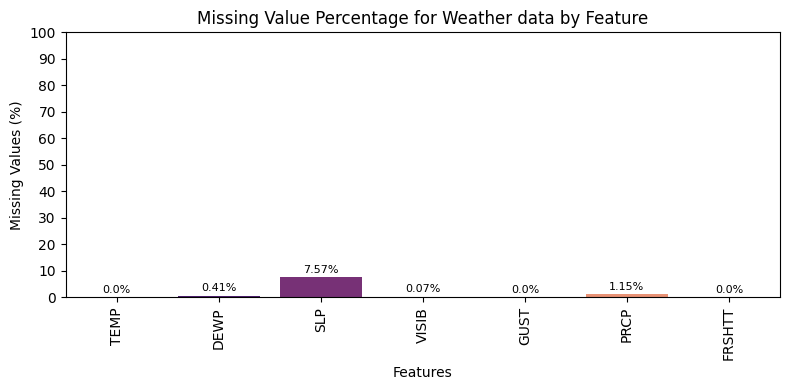

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate missing value percentages for all columns
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent.round(2)
missing_percent = missing_percent.drop('DDMMYYYYIATA', errors='ignore')

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="magma")
plt.title("Missing Value Percentage for Weather data by Feature")
plt.ylabel("Missing Values (%)")
plt.xlabel("Features")
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.xticks(rotation=90)

for i, v in enumerate(missing_percent.values):
    plt.text(i, v + 1, f'{v}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

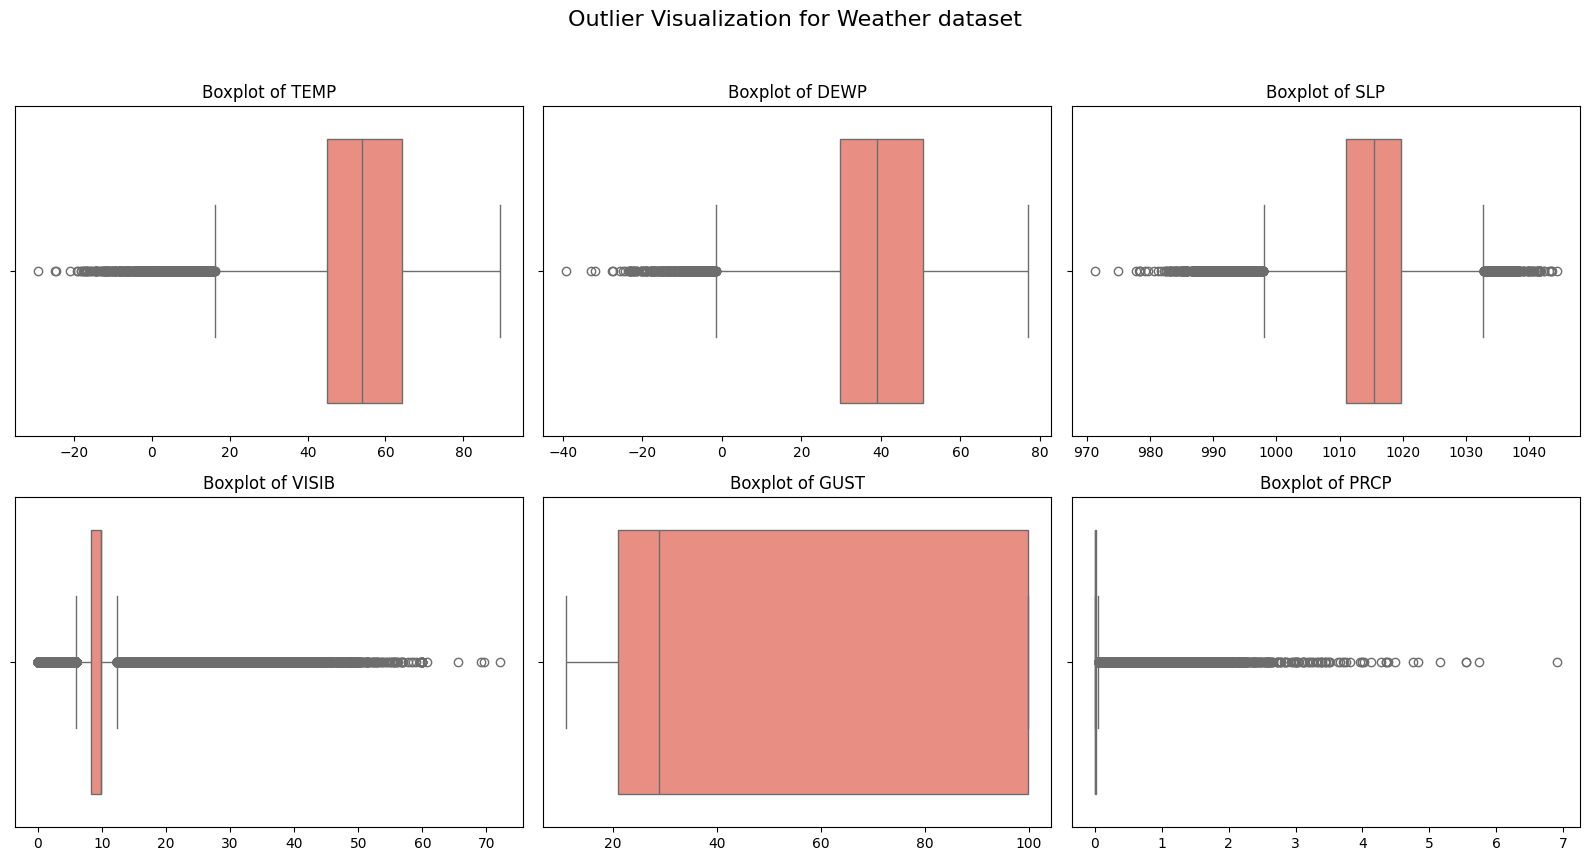

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'FRSHTT' in numeric_cols:
    numeric_cols.remove('FRSHTT')
selected_cols = numeric_cols[:9]

plt.figure(figsize=(16, 12))
for i, col in enumerate(selected_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')
    plt.xlabel('')

plt.suptitle('Outlier Visualization for Weather dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [6]:
# Display count of missing (NaN) values for each column
missing_data = df.isna().sum()

# Display the columns that have missing data and their counts
print("Missing values in each column:")
print(missing_data[missing_data > 0])

Missing values in each column:
DEWP      319
SLP      5845
VISIB      54
PRCP      887
dtype: int64


Fill missing values with mean

In [7]:
df['VISIB'] = df['VISIB'].fillna(df['VISIB'].mean())
df['PRCP'] = df['PRCP'].fillna(0)
df['SLP'] = df['SLP'].fillna(df['SLP'].mean())
df['DEWP'] = df['DEWP'].fillna(df['DEWP'].mean())
df['TEMP'] = df['TEMP'].fillna(df['TEMP'].mean())
df['GUST'] = df['GUST'].fillna(df['GUST'].mean())
df['FRSHTT'] = df['FRSHTT'].fillna(0)

In [8]:
# Display count of missing (NaN) values for each column
missing_data = df.isna().sum()

# Display the columns that have missing data and their counts
print("Missing values in each column:")
print(missing_data[missing_data > 0])

Missing values in each column:
Series([], dtype: int64)


Check for outliers

In [9]:
import pandas as pd

# Filter numeric columns starting with 'WEATHER_'
weather_numeric_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

# Dictionary to store summary
weather_outlier_summary = []

# Loop through each weather column
for col in weather_numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    total_count = df[col].count()

    if total_count == 0:
        outlier_pct = 0
    else:
        outlier_pct = (outlier_count / total_count) * 100

    weather_outlier_summary.append({
        'Column': col,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Lower Bound': round(lower_bound, 2),
        'Upper Bound': round(upper_bound, 2),
        'Outlier Count': outlier_count,
        'Total Count': total_count,
        'Outlier %': round(outlier_pct, 2)
    })

# Convert to DataFrame and sort
outlier_df = pd.DataFrame(weather_outlier_summary).sort_values(by='Outlier %', ascending=False)

# Display the formatted table
print(outlier_df.to_string(index=False))


Column     Q1        Q3       IQR  Lower Bound  Upper Bound  Outlier Count  Total Count  Outlier %
  PRCP    0.0      0.02      0.02        -0.03         0.05          15046        77168      19.50
 VISIB    8.3      9.90      1.60         5.90        12.30          11930        77168      15.46
   SLP 1011.5   1019.30      7.80       999.80      1031.00           2149        77168       2.78
  TEMP   45.0     64.20     19.20        16.20        93.00            847        77168       1.10
  DEWP   29.8     50.50     20.70        -1.25        81.55            384        77168       0.50
  GUST   21.0     99.90     78.90       -97.35       218.25              0        77168       0.00
FRSHTT    0.0 100000.00 100000.00   -150000.00    250000.00              0        77168       0.00


Create a weather condition column based on last three days weather

In [10]:
import pandas as pd

df['FRSHTT'] = df['FRSHTT'].fillna(0).astype(int).astype(str).str.zfill(6)

# Step 1: Clean and expand FRSHTT
frshtt_cols = ['FOG', 'RAIN', 'SNOW', 'HAIL', 'THUNDER', 'TORNADO']
for i, col in enumerate(frshtt_cols):
    df[f'WEATHER_{col}'] = df['FRSHTT'].str[i].astype(int)

# Step 2: Extract date and IATA
df['DATE'] = pd.to_datetime(df['DDMMYYYYIATA'].str[:8], format='%d%m%Y', errors='coerce')
df['IATA'] = df['DDMMYYYYIATA'].str[8:]

# Step 3: Sort the data
df = df.sort_values(by=['IATA', 'DATE'])

# Step 4: Rolling logic with fallback to fewer days or today's value
for col in frshtt_cols:
    # Get past 3 days (excluding today)
    rolled = (
        df
        .groupby('IATA')[f'WEATHER_{col}']
        .apply(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
        .reset_index(level=0, drop=True)
    )

    # Fill missing rolling values with fewer day fallback or today's value
    df[f'AVG3_{col}'] = rolled.fillna(df[f'WEATHER_{col}'])

# Step 5: Classify weather condition
def classify_weather(row):
    if row['AVG3_TORNADO'] >= 0.2 or row['AVG3_HAIL'] >= 0.2:
        return 'stormy'
    elif row['AVG3_THUNDER'] >= 0.2:
        return 'thunderstorm'
    elif row['AVG3_RAIN'] >= 0.3:
        return 'rainy'
    elif row['AVG3_SNOW'] >= 0.2:
        return 'snowy'
    elif row['AVG3_FOG'] >= 0.3:
        return 'foggy'
    else:
        return 'clear'

df['WEATHER_CONDITION'] = df.apply(classify_weather, axis=1)

# Step 6: Cleanup intermediate columns
to_drop = [f'WEATHER_{col}' for col in frshtt_cols] + [f'AVG3_{col}' for col in frshtt_cols] + ['DATE', 'IATA']
df.drop(columns=to_drop, inplace=True)

# Done. Preview result
df.head(10)


,TEMP,DEWP,SLP,VISIB,GUST,PRCP,FRSHTT,DDMMYYYYIATA,WEATHER_CONDITION
19041,70.1,67.9,1015.4,5.400000,99.9,0.29,010000,01041999AAF,rainy
19042,71.0,68.0,1016.3,6.300000,99.9,0.38,100000,02041999AAF,rainy
19043,68.1,65.7,1016.6,7.000000,99.9,0.01,100000,03041999AAF,rainy
19044,70.1,66.8,1017.2,4.500000,99.9,0.01,100000,04041999AAF,rainy
19045,72.1,67.6,1016.8,6.100000,99.9,0.01,100000,05041999AAF,foggy
19046,71.2,65.1,1019.6,7.600000,99.9,0.00,000000,06041999AAF,foggy
19047,70.9,66.4,1022.2,5.400000,99.9,0.01,000000,07041999AAF,foggy
19048,76.2,69.3,1019.4,6.900000,99.9,0.00,000000,08041999AAF,foggy
19049,76.1,69.6,1015.1,7.500000,23.9,0.00,000000,09041999AAF,clear
19050,76.5,69.9,1013.4,10.204097,21.0,0.00,000000,10041999AAF,clear


In [11]:
df.to_csv("/content/FinalizedWeather_Data.csv", index=False)

In [14]:
df.head()

,TEMP,DEWP,SLP,VISIB,GUST,PRCP,FRSHTT,DDMMYYYYIATA,WEATHER_CONDITION
19041,70.1,67.9,1015.4,5.4,99.9,0.29,010000,01041999AAF,rainy
19042,71.0,68.0,1016.3,6.3,99.9,0.38,100000,02041999AAF,rainy
19043,68.1,65.7,1016.6,7.0,99.9,0.01,100000,03041999AAF,rainy
19044,70.1,66.8,1017.2,4.5,99.9,0.01,100000,04041999AAF,rainy
19045,72.1,67.6,1016.8,6.1,99.9,0.01,100000,05041999AAF,foggy


In [17]:
import pandas as pd
flight_df = pd.read_csv("/content/df_cleaned.csv")

In [18]:
flight_df.head()

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_TIME,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
0,1998,1,3,AA,ABQ,NM,DFW,TX,548.0,0.0,-1.0,11.0,559.0,0.0,0.0,0.0,96.0,569.0,3
1,1998,1,3,AA,ABQ,NM,DFW,TX,703.0,0.0,-1.0,12.0,715.0,0.0,0.0,0.0,102.0,569.0,3
2,1998,1,3,AA,ABQ,NM,DFW,TX,856.0,0.0,-1.0,10.0,906.0,0.0,0.0,0.0,108.0,569.0,3
3,1998,1,3,AA,ABQ,NM,DFW,TX,1334.0,0.0,0.0,9.0,1343.0,0.0,0.0,0.0,100.0,569.0,3
4,1998,1,3,AA,ABQ,NM,DFW,TX,1635.0,0.0,-1.0,12.0,1647.0,0.0,0.0,0.0,104.0,569.0,3


Create a common column in flight data for merging weather and airport data: DDMMYYYYYIATA

In [19]:
# Function to convert flight data into DDMMYYYYIATA format
def convert_to_ddmmyyyy_iata_flight(row):
    # Extract day, month, year, and origin airport code
    day = str(row['DAY_OF_MONTH']).zfill(2)  # Ensure day is two digits
    month = "04"  # Ensure month is two digits
    year = str(row['YEAR'])  # Four digit year
    origin = row['ORIGIN']  # Origin airport code

    # Combine them into DDMMYYYYIATA format
    formatted_date = f"{day}{month}{year}{origin}"

    return formatted_date

# Apply the conversion to each row and create the new column
flight_df['DDMMYYYYIATA'] = flight_df.apply(convert_to_ddmmyyyy_iata_flight, axis=1)

# Display the result (first few rows)
print(flight_df[['YEAR', 'DAY_OF_MONTH', 'ORIGIN', 'DDMMYYYYIATA']].head())

print(len(flight_df))
# Optional: Save the updated dataset
flight_df.to_csv("/content/FinalFlight_Data.csv", index=False)


   YEAR  DAY_OF_MONTH ORIGIN DDMMYYYYIATA
0  1998             1    ABQ  01041998ABQ
1  1998             1    ABQ  01041998ABQ
2  1998             1    ABQ  01041998ABQ
3  1998             1    ABQ  01041998ABQ
4  1998             1    ABQ  01041998ABQ
2265248


Merge records based on DDMMYYYYYIATA

In [20]:
import pandas as pd
from tqdm import tqdm

# === Parameters ===
start_index = 0
chunk_size = 500_000
output_prefix = "/content/Merge_part"

# === Load datasets ===
weather_df = pd.read_csv("/content/FinalizedWeather_Data.csv")
april_df = pd.read_csv("/content/FinalFlight_Data.csv")
print("Loaded datasets")

# === Rename weather columns to avoid collision ===
weather_df = weather_df.add_prefix("WEATHER_")
weather_df.rename(columns={"WEATHER_DDMMYYYYIATA": "DDMMYYYYIATA"}, inplace=True)

# === Sort and set index for faster matching ===
weather_df.sort_values(by="DDMMYYYYIATA", inplace=True)
april_df.sort_values(by="DDMMYYYYIATA", inplace=True)
weather_df.set_index("DDMMYYYYIATA", inplace=True)

# === Merge process ===
merged_chunk = []
file_index = (start_index // chunk_size) + 1

for i in tqdm(range(start_index, len(april_df)), desc="Merging", ncols=100):
    flight_row = april_df.iloc[i]
    flight_key = flight_row["DDMMYYYYIATA"]

    # Find matching weather record
    if flight_key in weather_df.index:
        weather_row = weather_df.loc[flight_key]
        if isinstance(weather_row, pd.DataFrame):
            weather_row = weather_row.iloc[0]
        # Combine both rows into a single Series with no duplicate columns
        merged_row = pd.concat([flight_row, weather_row])
    else:
        merged_row = flight_row

    merged_chunk.append(merged_row)

    if len(merged_chunk) >= chunk_size or i == len(april_df) - 1:
        out_df = pd.DataFrame(merged_chunk)
        out_df.to_csv(f"{output_prefix}{file_index}.csv", index=False)
        print(f"Saved {output_prefix}{file_index}.csv with {len(out_df)} records.")
        file_index += 1
        merged_chunk = []


Loaded datasets


Merging:  22%|█████████▎                                | 500317/2265248 [03:53<21:32:33, 22.76it/s]

Saved /content/Merge_part1.csv with 500000 records.


Merging:  44%|██████████████████                       | 1000372/2265248 [07:37<13:15:25, 26.50it/s]

Saved /content/Merge_part2.csv with 500000 records.


Merging:  66%|███████████████████████████▏             | 1500000/2265248 [11:18<11:53:59, 17.86it/s]

Saved /content/Merge_part3.csv with 500000 records.


Merging:  88%|█████████████████████████████████████     | 2000000/2265248 [15:02<5:47:51, 12.71it/s]

Saved /content/Merge_part4.csv with 500000 records.


Merging: 100%|██████████████████████████████████████████| 2265248/2265248 [17:01<00:00, 2216.50it/s]

Saved /content/Merge_part5.csv with 265248 records.


In [43]:
print(len(weather_df))
print(len(april_df))

77168
290276


Merge all chunks to create the final dataset

In [21]:
import pandas as pd
import glob
import os

# === Folder and pattern where your chunked files are stored ===
folder_path = '.'  # Use "." if you're in the same folder
file_pattern = os.path.join(folder_path, '/content/Merge_part*.csv')

# === Grab all matching CSV file paths ===
csv_files = sorted(glob.glob(file_pattern))  # Sort to maintain order

print(f"Found {len(csv_files)} files to merge.")

# === Read and concatenate ===
merged_df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# === Save final merged CSV ===
merged_df.to_csv('Merged_April_Flight_Weather.csv', index=False)
print("Merged CSV saved as Merged_April_Flight_Weather.csv")


Found 5 files to merge.
Merged CSV saved as Merged_April_Flight_Weather.csv


In [22]:
print(len(merged_df))

2265248


In [23]:
merged_df.head()

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_TIME,DEP_DEL15,...,DISTANCE_GROUP,DDMMYYYYIATA,WEATHER_TEMP,WEATHER_DEWP,WEATHER_SLP,WEATHER_VISIB,WEATHER_GUST,WEATHER_PRCP,WEATHER_FRSHTT,WEATHER_WEATHER_CONDITION
0,1998,1,3,UA,ABE,PA,ORD,IL,1309.0,0.0,...,3,01041998ABE,68.7,61.0,1008.8,8.8,21.0,0.0,111110.0,stormy
1,1998,1,3,UA,ABE,PA,ORD,IL,919.0,0.0,...,3,01041998ABE,68.7,61.0,1008.8,8.8,21.0,0.0,111110.0,stormy
2,1998,1,3,UA,ABE,PA,ORD,IL,1719.0,0.0,...,3,01041998ABE,68.7,61.0,1008.8,8.8,21.0,0.0,111110.0,stormy
3,1998,1,3,US,ABE,PA,CLT,NC,819.0,0.0,...,2,01041998ABE,68.7,61.0,1008.8,8.8,21.0,0.0,111110.0,stormy
4,1998,1,3,US,ABE,PA,PIT,PA,729.0,0.0,...,2,01041998ABE,68.7,61.0,1008.8,8.8,21.0,0.0,111110.0,stormy


In [24]:
# Display NaNs count and percentage per column
import pandas as pd

df = pd.read_csv("/content/Merged_April_Flight_Weather.csv")
nan_summary = df.isna().sum().to_frame(name='NaN Count')
nan_summary['% Missing'] = (nan_summary['NaN Count'] / len(df)) * 100

# Sort by percentage missing, descending
nan_summary = nan_summary[nan_summary['NaN Count'] > 0].sort_values(by='% Missing', ascending=False)

print(nan_summary)

                           NaN Count  % Missing
WEATHER_TEMP                   90522   3.996119
WEATHER_DEWP                   90522   3.996119
WEATHER_SLP                    90522   3.996119
WEATHER_VISIB                  90522   3.996119
WEATHER_GUST                   90522   3.996119
WEATHER_PRCP                   90522   3.996119
WEATHER_FRSHTT                 90522   3.996119
WEATHER_WEATHER_CONDITION      90522   3.996119


Drop columns with more than 30% missing data

In [25]:
# List of columns to drop
columns_to_drop = [
    'CANCELLATION_CODE'
]

# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Confirm
print(f"Dropped {len(columns_to_drop)} columns. Remaining columns: {df.shape[1]}")

Dropped 1 columns. Remaining columns: 28


Handle missing values

In [26]:
df.loc[:, 'ARR_DEL15'] = df['ARR_DEL15'].fillna(df['ARR_DEL15'].mode()[0])
df_cleaned = df.dropna()

In [27]:
nan_summary = df_cleaned.isna().sum().to_frame(name='NaN Count')
nan_summary['% Missing'] = (nan_summary['NaN Count'] / len(df_cleaned)) * 100

# Sort by percentage missing, descending
nan_summary = nan_summary[nan_summary['NaN Count'] > 0].sort_values(by='% Missing', ascending=False)

print(nan_summary)

Empty DataFrame
Columns: [NaN Count, % Missing]
Index: []


In [28]:
df.to_csv('Final_dataset.csv', index=False)

<ipython-input-31-ea36d833085a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_counts.index, y=delay_counts.values, palette='flare')


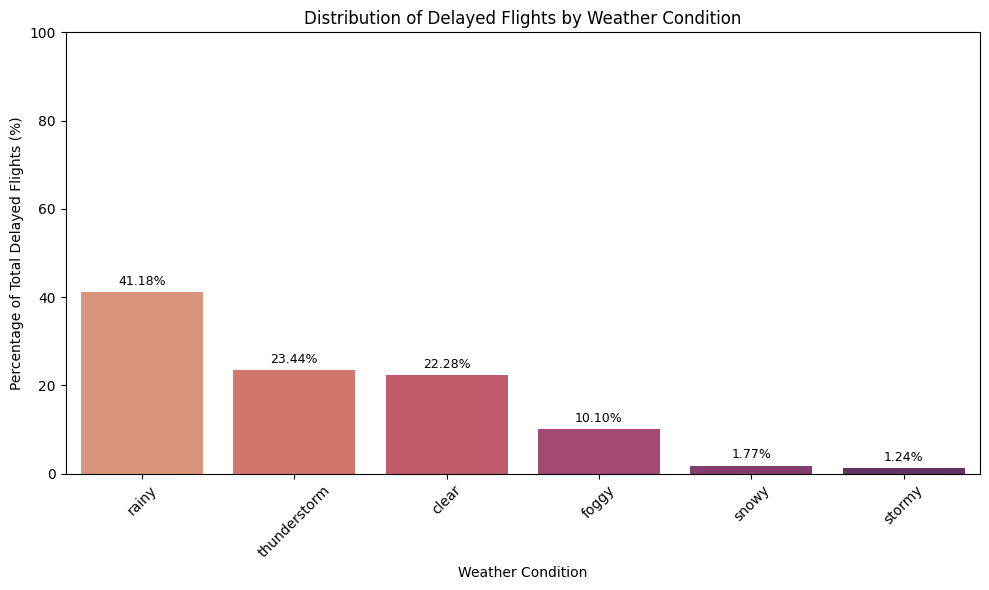

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to only delayed flights
delayed_flights = df[df['ARR_DEL15'] == 1]

# Count and normalize by weather condition
delay_counts = delayed_flights['WEATHER_WEATHER_CONDITION'].value_counts(normalize=True) * 100
delay_counts = delay_counts.round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=delay_counts.index, y=delay_counts.values, palette='flare')
plt.title("Distribution of Delayed Flights by Weather Condition")
plt.ylabel("Percentage of Total Delayed Flights (%)")
plt.xlabel("Weather Condition")
plt.ylim(0, 100)
plt.xticks(rotation=45)

# Annotate each bar
for i, v in enumerate(delay_counts.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


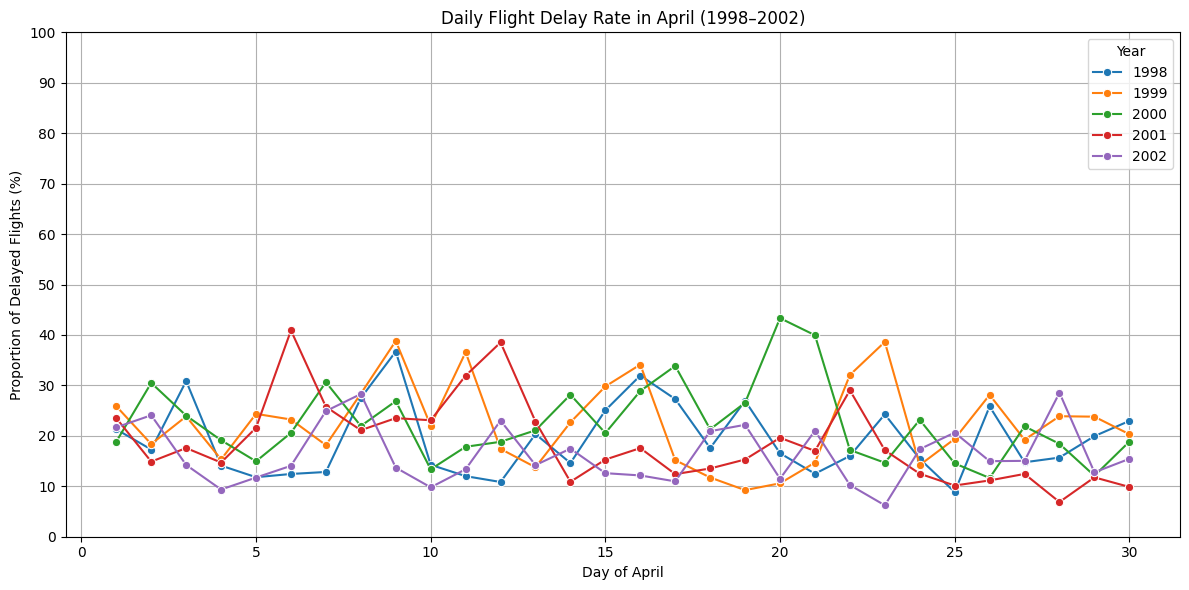

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only April data, assuming 'MONTH' exists and is 4 for April
if 'YEAR' in df.columns and 'DAY_OF_MONTH' in df.columns:

    # Group by day and year, calculate average delay rate
    daily_delay = april_df.groupby(['YEAR', 'DAY_OF_MONTH'])['ARR_DEL15'].mean().reset_index()
    daily_delay['ARR_DEL15'] = (daily_delay['ARR_DEL15'] * 100).round(2)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=daily_delay, x='DAY_OF_MONTH', y='ARR_DEL15', hue='YEAR', palette='tab10', marker='o')

    plt.title("Daily Flight Delay Rate in April (1998–2002)")
    plt.xlabel("Day of April")
    plt.ylabel("Proportion of Delayed Flights (%)")
    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))
    plt.legend(title="Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'MONTH', 'YEAR', or 'DAY_OF_MONTH' are missing.")


PCA for data reduction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric columns, excluding 'ACTUAL_ELAPSED_TIME'
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'ACTUAL_ELAPSED_TIME']

# Create numeric_df with only the selected columns
numeric_df = df_cleaned[numeric_cols]

# Step 2: Fill missing values with column mean
numeric_df_filled = numeric_df.fillna(numeric_df.mean())

# Step 3: Correlation Analysis
corr_matrix = numeric_df_filled.corr().abs()

# Get all strongly correlated pairs (> 0.9)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # remove self-correlation
strong_corr = corr_pairs[corr_pairs > 0.8]

print("Highly Correlated Pairs (Correlation > 0.8):\n")
print(strong_corr)

# Step 4: Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df_filled)

# Step 5: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

# Step 6: PCA Loadings
pca_loadings = pd.DataFrame(pca.components_, columns=numeric_df.columns, index=['PC1', 'PC2'])

# Show top 5 absolute contributors to PC1
top_5_pc1 = pca_loadings.loc['PC1'].abs().sort_values(ascending=False).head(5)
print("\nTop 5 PCA Features (PC1):\n")
print(top_5_pc1)

# Optional: PCA result as DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
print("\nPCA Transformed Sample:\n")
print(pca_df.head())


Highly Correlated Pairs (Correlation > 0.8):

DISTANCE_GROUP    DISTANCE            0.987137
DISTANCE          DISTANCE_GROUP      0.987137
CRS_ELAPSED_TIME  DISTANCE            0.984659
DISTANCE          CRS_ELAPSED_TIME    0.984659
DEP_TIME          WHEELS_OFF          0.974512
WHEELS_OFF        DEP_TIME            0.974512
DISTANCE_GROUP    CRS_ELAPSED_TIME    0.973226
CRS_ELAPSED_TIME  DISTANCE_GROUP      0.973226
dtype: float64

Top 5 PCA Features (PC1):

DISTANCE            0.565487
CRS_ELAPSED_TIME    0.565421
DISTANCE_GROUP      0.563209
TAXI_OUT            0.170359
ARR_DEL15           0.087622
Name: PC1, dtype: float64

PCA Transformed Sample:

        PC1       PC2
0 -0.421470 -0.188980
1 -0.431947 -0.785378
2 -0.421709  0.391575
3 -0.846308 -0.700878
4 -1.545009 -0.928317


In [ ]:
from collections import defaultdict

# Helper: Find groups of mutually correlated features
def build_corr_buckets(corr_matrix, threshold=0.8):
    visited = set()
    buckets = []

    for col in corr_matrix.columns:
        if col not in visited:
            # Find all features correlated to this one above the threshold
            correlated = set(corr_matrix[col][corr_matrix[col] > threshold].index)
            correlated.add(col)

            # Check if it's a new group
            if correlated not in buckets:
                buckets.append(correlated)
                visited.update(correlated)
    return buckets

# Generate buckets
corr_buckets = build_corr_buckets(corr_matrix, threshold=0.8)

# Print the buckets
print("\nHighly Correlated Column Buckets (Threshold > 0.8):\n")
for i, group in enumerate(corr_buckets, 1):
    if len(group) > 1:  # Ignore singletons
        print(f"Group {i}: {sorted(group)}")



Highly Correlated Column Buckets (Threshold > 0.8):

Group 4: ['DEP_TIME', 'WHEELS_OFF']
Group 11: ['CRS_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP']


In [ ]:
#Dropping redundant columns from PCA

# From DISTANCE, DISTANCE_GROUP, CRS_ELAPSED_TIME, and ACTUAL_ELAPSED_TIME, keep only DISTANCE_GROUP.
df = df.drop(columns=['DISTANCE', 'CRS_ELAPSED_TIME'])

# Between DEP_TIME and WHEELS_OFF, keep only DEP_TIME
df = df.drop(columns=['WHEELS_OFF'])

In [ ]:
print(df.head())

   YEAR  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN ORIGIN_STATE_ABR  \
0  1998             1            3                UA    ABE               PA   
1  1998             1            3                UA    ABE               PA   
2  1998             1            3                UA    ABE               PA   
3  1998             1            3                US    ABE               PA   
4  1998             1            3                US    ABE               PA   

  DEST DEST_STATE_ABR  DEP_TIME  DEP_DEL15  ...  DISTANCE_GROUP  DDMMYYYYIATA  \
0  ORD             IL    1309.0        0.0  ...               3   01041998ABE   
1  ORD             IL     919.0        0.0  ...               3   01041998ABE   
2  ORD             IL    1719.0        0.0  ...               3   01041998ABE   
3  CLT             NC     819.0        0.0  ...               2   01041998ABE   
4  PIT             PA     729.0        0.0  ...               2   01041998ABE   

   WEATHER_TEMP  WEATHER_DEWP  W

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical and categorical columns after dropping columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Ensure 'ARR_DEL15' is not in your feature lists (since it's the target)
numeric_features = [f for f in numeric_features if f != 'ARR_DEL15']
categorical_features = [f for f in categorical_features if f != 'ARR_DEL15']

# Define features and target
target_column = 'ARR_DEL15'
y = df[target_column]
X = df.drop(columns=[target_column])

# ColumnTransformer: Scaling numeric + encoding categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),   # Standardize
        ]), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ]
)

# Full pipeline with XGBoost
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:37:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy Score: 0.9685948229750244

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98    372253
         1.0       0.94      0.90      0.92     89518

    accuracy                           0.97    461771
   macro avg       0.96      0.94      0.95    461771
weighted avg       0.97      0.97      0.97    461771


Confusion Matrix:
 [[366865   5388]
 [  9114  80404]]
